In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

## Importing the Data

In [2]:
# importing dataset
df = pd.read_csv('Data/final_data.csv', header=None)
df.rename(columns={0: 'comment', 1: 'category'}, inplace=True)

## Exploring the Data

In [3]:
df.head()

,comment,category
0,Love you sir!!,positive
1,Please make videos on..Midpoint circle drawing...,imperative
2,I bought both of your courses on Udemy. You ar...,interrogative
3,"Thank you very much, u really got me in the fi...",positive
4,i hope u are ok with everything going on again...,miscellaneous


In [4]:
# dimension of the dataset
df.shape

(10000, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comment   10000 non-null  object
 1   category  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [6]:
df.describe()

,comment,category
count,10000,10000
unique,9783,6
top,great explanation,positive
freq,19,3648


In [7]:
# unique categories
df['category'].unique()

array(['positive', 'imperative', 'interrogative', 'miscellaneous',
       'corrective', 'negative'], dtype=object)

In [8]:
lens = df.comment.str.len()
lens.mean(), lens.std(), lens.max()

(103.4091, 143.0047431830402, 4124)

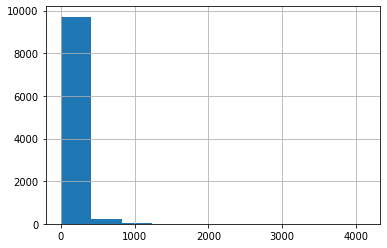

In [9]:
lens.hist();

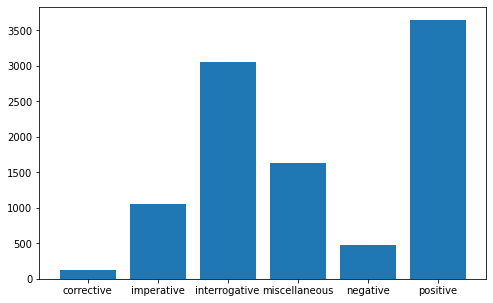

In [10]:
categories = df.groupby('category').size()

y_pos = categories.index
 
plt.figure(figsize=(8,5))
    
# Create bars
plt.bar(y_pos, categories.values)
 
# Show graphic
plt.show()

## Preprocessing

In [11]:
# lowercasing
df['comment'] = df['comment'].str.lower()
df['comment']

0                                          love you sir!!
1       please make videos on..midpoint circle drawing...
2       i bought both of your courses on udemy. you ar...
3       thank you very much, u really got me in the fi...
4       i hope u are ok with everything going on again...
                              ...                        
9995    this is gold! absolute peach of a video. but i...
9996    this is helpful, how to decode a logical conte...
9997    wow. reading this slowly actually helped me se...
9998    great video sir, really helped a lot.keep goin...
9999    oh damn! u deserve a lot many subscribers than...
Name: comment, Length: 10000, dtype: object

In [12]:
# checking for NaN values
df.isnull().sum()

comment     0
category    0
dtype: int64

There is no **NaN** value in the dataset.

In [13]:
# checking for duplicate 
df.duplicated().any()

True

Duplicate row is present. Let's remove the duplicate rows.

In [14]:
# # removing duplicate rows
# df = df.drop_duplicates()
# df.duplicated().any()

Duplicated removed succefully.

In [15]:
# Preprocessing

# removing urls
df['comment'] = df['comment'].str.replace('http\S+|www.\S+', '', case=False)

# removing new lines "\n"
df['comment'] = df['comment'].replace('\n','', regex=True)

# removing all the punctuations
df['comment'] = df['comment'].str.replace('[^\w\s]',' ')

# removing integers
df['comment'] = df['comment'].replace('\d','', regex=True)

# removing emojis
df['comment'] = df['comment'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
df

/var/folders/f7/7wm8ypsx1_zcy_df6_f5nrl40000gn/T/ipykernel_40290/3288102125.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment'] = df['comment'].str.replace('http\S+|www.\S+', '', case=False)
/var/folders/f7/7wm8ypsx1_zcy_df6_f5nrl40000gn/T/ipykernel_40290/3288102125.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment'] = df['comment'].str.replace('[^\w\s]',' ')
/var/folders/f7/7wm8ypsx1_zcy_df6_f5nrl40000gn/T/ipykernel_40290/3288102125.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment'] = df['comment'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)


,comment,category
0,love you sir,positive
1,please make videos on midpoint circle drawing...,imperative
2,i bought both of your courses on udemy you ar...,interrogative
3,thank you very much u really got me in the fi...,positive
4,i hope u are ok with everything going on again...,miscellaneous
...,...,...
9995,this is gold absolute peach of a video but i...,positive
9996,this is helpful how to decode a logical conte...,interrogative
9997,wow reading this slowly actually helped me se...,positive
9998,great video sir really helped a lot keep goin...,positive


In [16]:
# removing punctuations except ! and ?
# import string

# def remove_punctuations(text):
    
#     punct = string.punctuation
#     punct = punct.replace('!', '')
#     punct = punct.replace('?', '')
    
#     for punctuation in punct:
#         text = text.replace(punctuation, '')
#     return text

# df["comment"] = df['comment'].apply(remove_punctuations)
# df


In [17]:
# # replacing sequence of "!" with single "!"
# def replace(string, char): 
#     pattern = char + '{2,}'
#     string = re.sub(pattern, char, string)
#     return string 

# char = '!'

# df_ = pd.DataFrame(columns=['comment', 'category'])

# for index, row in df.iterrows():
#     df_ = df_.append({'comment':replace(row['comment'], char), 'category':row['category']}, ignore_index=True)

# df_

In [18]:
# # replacing sequence of "?" with single "?"
# def replace_q(string):
#     char = '?'
#     string = re.sub('[?-?]+', char, string)
#     return string

# df_['comment'] = df_['comment'].apply(replace_q)
# df_

In [19]:
# correcting the typos
from autocorrect import Speller

spell = Speller(lang='en')

def typo_corrector(text):
    return spell(text)

df['comment'] = df['comment'].apply(typo_corrector)
df

,comment,category
0,love you sir,positive
1,please make videos on midpoint circle drawing...,imperative
2,i bought both of your courses on dmy you are ...,interrogative
3,thank you very much u really got me in the fi...,positive
4,i hope u are ok with everything going on again...,miscellaneous
...,...,...
9995,this is gold absolute peach of a video but i...,positive
9996,this is helpful how to decode a logical conte...,interrogative
9997,wow reading this slowly actually helped me se...,positive
9998,great video sir really helped a lot keep goin...,positive


In [20]:
# # tokenizing
# df_['comment'] = df_.apply(lambda row: nltk.word_tokenize(row['comment']), axis=1)
# df_

In [21]:
# # removing stopwords
# stop = stopwords.words('english')
# negative_words = ['nor','no','not']
# for word in negative_words:
#     stop.remove(word)

# df['comment'] = df['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# df



# Removing stopwords
stop = stopwords.words('english')

# These are the words that should not be removed from their category
negative_words = ['no','not']
interrogative_words = ['how','what','which','who','whom','why','do','does','is','are','was','were','will','am',
                      'are','could','would','should','can','did','does','do','had','have']
imperative_words = ['could','would','should','can']

for_negative_category = stop.copy()
for word in negative_words:
    if word in for_negative_category:
        for_negative_category.remove(word)
    
for_interrogative_category = stop.copy()
for word in interrogative_words:
    if word in for_interrogative_category:
        for_interrogative_category.remove(word)
    
for_imperative_category = stop.copy()
for word in imperative_words:
    if word in for_imperative_category:
        for_imperative_category.remove(word)

# For negative words
for i in range(len(df)):
    if df['category'][i] == "negative":
        df['comment'][i] = ' '.join([word for word in df['comment'][i].split() if word not in for_negative_category])

# For interrogative words
for i in range(len(df)):
    if df['category'][i] == "interrogative":
        df['comment'][i] = ' '.join([word for word in df['comment'][i].split() if word not in for_interrogative_category])
        
# For interrogative words
for i in range(len(df)):
    if df['category'][i] == "imperative":
        df['comment'][i] = ' '.join([word for word in df['comment'][i].split() if word not in for_imperative_category])
        
# For all other category
for i in range(len(df)):
    if df['category'][i] == "positive" or df['category'][i] == "correction" or df['category'][i] == "other":
        df['comment'][i] = ' '.join([word for word in df['comment'][i].split() if word not in stop])

# df[0] = df[0].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# df


In [22]:
# # stemming
# stemmer = nltk.stem.SnowballStemmer('english')

# df['comment'] = df['comment'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# def stem_text(text):
#     return [stemmer.stem(w) for w in text]

# df_['comment'] = df_['comment'].apply(stem_text)


# # lemmatizing
# lemmatizer = nltk.stem.WordNetLemmatizer()
# def lemmatize_text(text):
#     return [lemmatizer.lemmatize(w) for w in text]

# df_['comment'] = df_['comment'].apply(lemmatize_text)
# df_

lemmatizer = nltk.stem.WordNetLemmatizer()
df['comment'] = df['comment'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

df

,comment,category
0,love sir,positive
1,please make video midpoint circle drawing bres...,imperative
2,bought course dmy are talented teacher keep pr...,interrogative
3,thank much u really got first video algorithm ...,positive
4,i hope u are ok with everything going on again...,miscellaneous
...,...,...
9995,gold absolute peach video messed last two ques...,positive
9996,is helpful how decode logical context easily s...,interrogative
9997,wow reading slowly actually helped see extra i...,positive
9998,great video sir really helped lot keep going l...,positive


## Feature Extraction

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=False, min_df=5, norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(df.comment).toarray()

features.shape

(10000, 4304)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, df.category, test_size=0.2, random_state=42)

In [ ]:
### Hyperparameter Tuning ###

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# define models and parameters
model = MultinomialNB()
fit_prior=[True, False]
alpha=[0,0.5,1]

# define grid search
grid = dict(fit_prior=fit_prior,alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
nb_alpha, nb_fit_prior = [], []


for sample in params:
    nb_alpha.append(sample['alpha'])

    nb_fit_prior.append(sample['fit_prior'])


nb_dict = {'mean_test_score': means, 
                    'alpha': nb_alpha,
                    'fit_prior': nb_fit_prior}

final_nb = pd.DataFrame(nb_dict)

In [ ]:
### Hyperparameter Tuning ###

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# define model and parameters
model = SVC()
kernel = ['linear','poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
svc_kernel, svc_C, svc_gamma = [], [], []


for sample in params:
    svc_kernel.append(sample['kernel'])
    svc_C.append(sample['C'])
    svc_gamma.append(sample['gamma'])


svc_dict = {'mean_test_score': means, 
                    'kernel': svc_kernel,
                    'C': svc_C,
                    'gamma': svc_gamma}

final_svc = pd.DataFrame(svc_dict)

In [ ]:
### Hyperparameter Tuning ###

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2', 'elasticnet', 'none']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
logistic_solvers, logistic_penalty, logistic_C = [], [], []


for sample in params:
    logistic_solvers.append(sample['solver'])
    logistic_penalty.append(sample['penalty'])
    logistic_C.append(sample['C'])


logistic_dict = {'mean_test_score': means, 
                    'solvers': logistic_solvers,
                    'penalty': logistic_penalty,
                    'C': logistic_C}

final_logistic = pd.DataFrame(logistic_dict)

In [ ]:
### Hyperparameter Tuning ###

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
criterion = ['gini', 'entropy']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features,criterion=criterion)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
randfor_n_estimators, randfor_max_features, randfor_criterion = [], [], []


for sample in params:
    randfor_n_estimators.append(sample['n_estimators'])
    randfor_max_features.append(sample['max_features'])
    randfor_criterion.append(sample['criterion'])


randfor_dict = {'mean_test_score': means, 
                    'n_estimators': randfor_n_estimators,
                    'max_features': randfor_max_features,
                    'criterion': randfor_criterion}

final_randfor = pd.DataFrame(randfor_dict)

In [25]:
### Hyperparameter Tuning ###

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# DecisionTreeClassifier(criterion='gini',max_depth=12, max_features='sqrt', min_samples_leaf=2, min_samples_split=5,random_state=0)

# define models and parameters
model = DecisionTreeClassifier()
#max_features = ['sqrt', 'log2', 'auto']
max_features = [None]
criterion = ['gini', 'entropy']
#max_depth = [2,4,6,8,10,12]
max_depth = [None]
min_samples_split = range(1,10)
min_samples_leaf = range(1,5)
# define grid search
grid = dict(max_depth=max_depth,max_features=max_features,criterion=criterion,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/mgw/opt/anaconda3/envs/cs680/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mgw/opt/anaconda3/envs/cs680/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mgw/opt/anaconda3/envs/cs680/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/Users/mgw/opt/anaconda3/envs/cs680/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 250, in fit
    raise ValueEr

Best: 0.811250 using {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 1}
0.811250 (0.013010) with: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.809958 (0.015879) with: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3}
0.809542 (0.016236) with: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4}
0.807833 (0.015626) with: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.807792 (0.014566) with: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6}
0.808958 (0.014635) with: {'criterion': 'gini', 'max_

In [26]:
dectree_max_features, dectree_criterion, dectree_max_depth, dectree_min_samples_split, dectree_min_samples_leaf = [], [], [], [], []


for sample in params:
    dectree_max_features.append(sample['max_features'])
    dectree_criterion.append(sample['criterion'])
    dectree_max_depth.append(sample['max_depth'])
    dectree_min_samples_split.append(sample['min_samples_split'])
    dectree_min_samples_leaf.append(sample['min_samples_leaf'])


dectree_dict = {'mean_test_score': means, 
                    'max_features': dectree_max_features,
                    'criterion': dectree_criterion,
                    'max_depth': dectree_max_depth,
                    'min_samples_split': dectree_min_samples_split,
                    'min_samples_leaf': dectree_min_samples_leaf}

final_dectree = pd.DataFrame(dectree_dict)

final_dectree.sort_values(by = 'mean_test_score', ascending=False).head(10).reset_index(drop=True)

,mean_test_score,max_features,criterion,max_depth,min_samples_split,min_samples_leaf
0,0.811250,None,gini,None,2,1
1,0.810667,None,entropy,None,8,1
2,0.810417,None,entropy,None,6,1
3,0.810125,None,entropy,None,2,1
4,0.810125,None,entropy,None,3,1
5,0.809958,None,gini,None,3,1
6,0.809958,None,entropy,None,4,1
7,0.809875,None,gini,None,8,1
8,0.809750,None,entropy,None,7,1
9,0.809542,None,gini,None,4,1


In [ ]:
# Final dataframes of all hyperparameter results (top 10 only)

#final_nb.sort_values(by = 'mean_test_score', ascending=False).head(10).reset_index(drop=True)

# final_svc.sort_values(by = 'mean_test_score', ascending=False).head(10).reset_index(drop=True)

# final_logistic.sort_values(by = 'mean_test_score', ascending=False).head(10).reset_index(drop=True)

# final_randfor.sort_values(by = 'mean_test_score', ascending=False).head(10).reset_index(drop=True)

# final_dectree.sort_values(by = 'mean_test_score', ascending=False).head(10).reset_index(drop=True)

In [ ]:

nb_dict = {'mean_test_score': [0.785833,
                                0.759958,
                                0.804583,
                                0.807917,
                                0.792333, 
                                0.814208],
            'alpha': [0, 0, 0.5, 0.5, 1, 1],
            'fit_prior': [True, False, True, False, True, False]}

final_nb = pd.DataFrame(nb_dict)

final_nb.sort_values(by = 'mean_test_score', ascending=False).head(10).reset_index(drop=True)

In [ ]:
'linear',
'poly',
'rbf',
'sigmoid',
'linear',
'poly',
'rbf',
'sigmoid',
'linear',
'poly',
'rbf',
'sigmoid',
'linear',
'poly',
'rbf',
'sigmoid',
'linear',
'poly',
'rbf',
'sigmoid',

svc_dict = {'mean_test_score': [0.841875, 
                                0.432500, 
                                0.862125, 
                                0.789458, 
                                0.844042, 
                                0.647333, 
                                0.862125, 
                                0.827417, 
                                0.862000, 
                                0.715500, 
                                0.856125, 
                                0.858833, 
                                0.779667, 
                                0.371833, 
                                0.701917, 
                                0.778583, 
                                0.395125, 
                                0.369000, 
                                0.369000, 
                                0.397500],
            'C': [50,
                    50,
                    50,
                    50,
                    10,
                    10,
                    10,
                    10,
                    1.0,
                    1.0,
                    1.0,
                    1.0,
                    0.1,
                    0.1,
                    0.1,
                    0.1,
                    0.01,
                    0.01,
                    0.01,
                    0.01], 
            'kernel': ['linear',
                        'poly',
                        'rbf',
                        'sigmoid',
                        'linear',
                        'poly',
                        'rbf',
                        'sigmoid',
                        'linear',
                        'poly',
                        'rbf',
                        'sigmoid',
                        'linear',
                        'poly',
                        'rbf',
                        'sigmoid',
                        'linear',
                        'poly',
                        'rbf',
                        'sigmoid']}

final_svc = pd.DataFrame(svc_dict)

final_svc.sort_values(by = 'mean_test_score', ascending=False).head(10).reset_index(drop=True)

In [ ]:
final_logistic.sort_values(by = 'mean_test_score', ascending=False).head(10).reset_index(drop=True)


In [ ]:

final_randfor.sort_values(by = 'mean_test_score', ascending=False).head(10).reset_index(drop=True)


In [ ]:

final_dectree.sort_values(by = 'mean_test_score', ascending=False).head(10).reset_index(drop=True)

## Applying ML Models

In [ ]:
# Applying models
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

labels = df['category']
# models = [
#     RandomForestClassifier(n_estimators=1000, max_features='log2', criterion='entropy', random_state=0),
#     LinearSVC(C = 1, random_state=0),
#     MultinomialNB(alpha=1, fit_prior=False,),
#     LogisticRegression(C=10, penalty='l2', solver='liblinear',random_state=0),
#     DecisionTreeClassifier(criterion='entropy',max_features=None,random_state=0),
# ]

models = [
    RandomForestClassifier(n_estimators=1000, max_features='sqrt', criterion='gini', random_state=0),
    SVC(C = 10, kernel = 'rbf', random_state=0),
    MultinomialNB(alpha=1, fit_prior=False,),
    LogisticRegression(C=10, penalty='l2', solver='liblinear',random_state=0),
    DecisionTreeClassifier(criterion='gini',max_depth=12, max_features='sqrt', min_samples_leaf=2, min_samples_split=5,random_state=0),
]


cv_df = pd.DataFrame()
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=10)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=10, jitter=True, linewidth=1)
plt.show()

In [ ]:
# Printing the accuracies
cv_df.groupby('model_name').accuracy.mean()

In [ ]:
# for scatter plot -> at the bottom
labels = np.unique(y_test)
acc_corrective = []
acc_imperative = []
acc_interrogative = []
acc_miscellaneous = []
acc_negative = []
acc_positive = []

# Function to show the accuracy of each class
def acc_each_class(cf_matrix):
    total_comments = cf_matrix.sum(axis=1)
    correctly_classified = np.diagonal(cf_matrix)
    accuracy_each_class = correctly_classified/total_comments
    return accuracy_each_class

In [ ]:
# Multinomial NB
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB(alpha=1, fit_prior=False,)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_mnb = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
accuracies = acc_each_class(cm_mnb)

acc_corrective.append(accuracies[0])
acc_imperative.append(accuracies[1])
acc_interrogative.append(accuracies[2])
acc_miscellaneous.append(accuracies[3])
acc_negative.append(accuracies[4])
acc_positive.append(accuracies[5])

In [ ]:
# ### Hyperparameter Tuning ###

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV
# # from sklearn.ensemble import MultinomialNB

# # define models and parameters
# model = MultinomialNB()
# fit_prior=[True, False]
# alpha=[0,0.5,1]

# # define grid search
# grid = dict(fit_prior=fit_prior,alpha=alpha)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Linear SVC
from sklearn.svm import SVC

# classifier = SVC(kernel = 'linear', random_state = 0, C = 1, gamma = 0.1)
classifier = SVC(kernel = 'linear', random_state = 0, C = 1, gamma = 'scale',)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_lsvc = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
accuracies = acc_each_class(cm_lsvc)

acc_corrective.append(accuracies[0])
acc_imperative.append(accuracies[1])
acc_interrogative.append(accuracies[2])
acc_miscellaneous.append(accuracies[3])
acc_negative.append(accuracies[4])
acc_positive.append(accuracies[5])

In [ ]:
# ### Hyperparameter Tuning ###

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# # define model and parameters
# model = SVC()
# kernel = ['linear','poly', 'rbf', 'sigmoid']
# C = [50, 10, 1.0, 0.1, 0.01]
# gamma = ['scale']
# # define grid search
# grid = dict(kernel=kernel,C=C,gamma=gamma)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# # Naive Bayes
# from sklearn.naive_bayes import GaussianNB

# classifier = GaussianNB()
# classifier.fit(X_train, y_train)

# # Predicting the Test set results
# y_pred = classifier.predict(X_test)

# # Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)

# print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(C=10, penalty='l2', solver='liblinear',random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
accuracies = acc_each_class(cm_lr)

acc_corrective.append(accuracies[0])
acc_imperative.append(accuracies[1])
acc_interrogative.append(accuracies[2])
acc_miscellaneous.append(accuracies[3])
acc_negative.append(accuracies[4])
acc_positive.append(accuracies[5])

In [ ]:
# acc_corrective

In [ ]:
# ### Hyperparameter Tuning ###

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression

# # define models and parameters
# model = LogisticRegression()
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
# penalty = ['l1', 'l2', 'elasticnet', 'none']
# c_values = [100, 10, 1.0, 0.1, 0.01]
# # define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# # KNN
# from sklearn.neighbors import KNeighborsClassifier

# classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
# classifier.fit(X_train, y_train)

# # Predicting the Test set results
# y_pred = classifier.predict(X_test)

# # Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)

# print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
# # Kernal SVC RBF

# classifier = SVC(kernel = 'rbf', random_state = 0)
# classifier.fit(X_train, y_train)

# # Predicting the Test set results
# y_pred = classifier.predict(X_test)

# # Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)

# print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
# # Kernal SVC sigmoid

# classifier = SVC(kernel = 'sigmoid', random_state = 0)
# classifier.fit(X_train, y_train)

# # Predicting the Test set results
# y_pred = classifier.predict(X_test)

# # Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)

# print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
# # Kernal SVC poly

# classifier = SVC(kernel = 'poly', random_state = 0)
# classifier.fit(X_train, y_train)

# # Predicting the Test set results
# y_pred = classifier.predict(X_test)

# # Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)

# print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(criterion='entropy', max_features='log2', n_estimators=1000, random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_rf = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
accuracies = acc_each_class(cm_rf)

acc_corrective.append(accuracies[0])
acc_imperative.append(accuracies[1])
acc_interrogative.append(accuracies[2])
acc_miscellaneous.append(accuracies[3])
acc_negative.append(accuracies[4])
acc_positive.append(accuracies[5])

In [ ]:
# ### Hyperparameter Tuning ###

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # define models and parameters
# model = RandomForestClassifier()
# n_estimators = [10, 100, 1000]
# max_features = ['sqrt', 'log2']
# criterion = ['gini', 'entropy']
# # define grid search
# grid = dict(n_estimators=n_estimators,max_features=max_features,criterion=criterion)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Decision Tree
# from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(criterion='entropy', 
                                    max_features=None, random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_dt = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
accuracies = acc_each_class(cm_dt)

acc_corrective.append(accuracies[0])
acc_imperative.append(accuracies[1])
acc_interrogative.append(accuracies[2])
acc_miscellaneous.append(accuracies[3])
acc_negative.append(accuracies[4])
acc_positive.append(accuracies[5])

In [ ]:
# ### Hyperparameter Tuning ###

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV

# # define models and parameters
# model = DecisionTreeClassifier()
# max_features = ['sqrt', 'log2', 'auto']
# criterion = ['gini', 'entropy']
# max_depth = [2,4,6,8,10,12]
# min_samples_split = range(1,10)
# min_samples_leaf = range(1,5)
# # define grid search
# grid = dict(max_depth=max_depth,max_features=max_features,criterion=criterion,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

## Histogram

In [ ]:
def acc_each_category(cf_matrix):
#     total_comments = cf_matrix.sum(axis=1)
    correctly_classified = np.diagonal(cf_matrix)
    return correctly_classified

y = cm_dt.sum(axis=1)

z1 = acc_each_category(cm_lsvc)
z2 = acc_each_category(cm_lr)
z3 = acc_each_category(cm_mnb)
z4 = acc_each_category(cm_rf)
z5 = acc_each_category(cm_dt)

In [ ]:
import matplotlib.pyplot as plt

x_tick = np.unique(y_test)
w = 0.125
x1 = np.array([1,2,3,4,5,6])
x2 = x1+w
x3 = x2+w
x4 = x3+w
x5 = x4+w
x6 = x5+w
x7 = x6+w

plt.xticks(ticks=x1+0.3, labels=x_tick)
plt.bar(x1, y, w, label = "Total Comments")
plt.bar(x2, z1, w, label = "Linear SVC")
plt.bar(x3, z2, w, label = "Logistic Regression",)
plt.bar(x4, z3, w, label = "Multinomial NB",)
plt.bar(x5, z4, w, label = "Random Forest Classifier")
plt.bar(x6, z5, w, label = "Decision Tree")


plt.rcParams["figure.figsize"] = (15,5)
plt.xlabel("Category")
plt.ylabel("Number of Comments")
plt.legend()
plt.show()

In [ ]:
def plot_acc_curve(classifier, linestyle, label):    
    
    num_of_splits = 14
    each_split_size = len(X_train)//num_of_splits

    each_split = 98
    scores = []

    for i in range(num_of_splits+1):
        split_X_train = X_train[0:each_split]
        split_y_train = y_train[0:each_split]

        each_split += each_split_size

        classifier.fit(split_X_train, split_y_train)
        scores.append(classifier.score(X_test, y_test))
    
    m = 14
    n = 98
    x_splits = list(range(0, (m+1)*n, n))

    plt.xlabel('Data Size')
    plt.ylabel('Testing Accuracy')
    plt.plot(x_splits, scores, linestyle, label = label)
    plt.xticks(x_splits)
    plt.legend(loc="best")
    
    return plt
    

plt.figure(figsize=(12,8))

# Linear SVC
classifier = SVC(kernel = 'linear', random_state = 0, C = 1, gamma = 'scale',)
plot_acc_curve(classifier, linestyle = 'o-', label="Linear SVC")

# Logistic Regression
classifier = LogisticRegression(C=10, penalty='l2', solver='liblinear',random_state = 0)
plot_acc_curve(classifier, linestyle = '*-', label="Logistic Regression")

# Multinomial NB
classifier = MultinomialNB(alpha=1, fit_prior=False,)
plot_acc_curve(classifier, linestyle = '^-', label="Multinomial NB")

# Random Forest Classifier
classifier = RandomForestClassifier(criterion='entropy', max_features='log2', n_estimators=1000, random_state = 0)
plot_acc_curve(classifier, linestyle = 's-', label="Random Forest Classifier")

# Decision Tree Classifier
classifier = DecisionTreeClassifier(criterion='entropy', 
                                    max_features=None, random_state=0)
plot_acc_curve(classifier, linestyle = 'x-', label="Decision Tree Classifier")

plt.show()

In [ ]:
corr = [i * 100 for i in acc_corrective]
imp = [i * 100 for i in acc_imperative]
inte = [i * 100 for i in acc_interrogative]
mis = [i * 100 for i in acc_miscellaneous]
neg = [i * 100 for i in acc_negative]
pos = [i * 100 for i in acc_positive]

In [ ]:
import matplotlib.pyplot as plt

# x1 = [10,20,30,40,50]
x1 = ['Linear SVC','Logistic Regression','Multinomial NB','Random Forest Classifier','Decision Tree Classifier']
# corrective
y1 = corr
# plotting the line 1 points 
plt.plot(x1, y1, label = "Corrective", marker='o')

# imperative
y2 = imp
# plotting the line 2 points 
plt.plot(x1, y2, label = "Imperative", marker='*')

# interrogative
y3 = inte
# plotting the line 2 points 
plt.plot(x1, y3, label = "Interrogative", marker='s')

# Miscellaneous
y4 = mis
# plotting the line 2 points 
plt.plot(x1, y4, label = "Miscellaneous", marker='.')

# Negative
y5 = neg
# plotting the line 2 points 
plt.plot(x1, y5, label = "Negative", marker='^')

# Positive
y6 = pos
# plotting the line 2 points 
plt.plot(x1, y6, label = "Positive", marker='+')


plt.xlabel('')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy Percentage')
# Set a title of the current axes.
plt.title('')
# show a legend on the plot
plt.legend()

plt.xticks(rotation=90)
# Display a figure.
plt.show()